In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

In [12]:
# splits = ['random', 'scaffold', 'protein', 'ecfp']
splits = ['random', 'scaffold', 'protein']
datasets = ['pdbbind']
tasks = ['all', 'easy', 'hard']
results_dir = '/home/bb596/hdd/pdbbind_bioactive/results/'
iterations = range(5)

In [10]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()

In [9]:
# 'median_normalized_bioactive_like_rank': 0.02,
# 'fraction_top_bioactive_like': 0.31719532554257096,

In [13]:
for split in splits :

    for iteration in iterations :
            
        experiment_name = f'{split}_split_{iteration}'
        evaluation_name = f'{experiment_name}'
        
        working_dir = os.path.join(results_dir, evaluation_name)
        for task in tasks :
            task_dir = os.path.join(working_dir, task)
            dataset_results_path = os.path.join(task_dir, f'dataset_results.p')
            with open(dataset_results_path, 'rb') as f:
                dataset_results = pickle.load(f)

            for ranker in ['model', 'energy', 'random'] :
                dataset_results['bioactive_accuracy'][ranker]['split'] = split
                dataset_results['bioactive_accuracy'][ranker]['dataset'] = dataset
                dataset_results['bioactive_accuracy'][ranker]['task'] = task
                dataset_results['bioactive_accuracy'][ranker]['ranker'] = ranker
                bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy'][ranker]), ignore_index=True)

            for average_type in dataset_results['regression'] :
                dataset_results['regression'][average_type]['split'] = split
                dataset_results['regression'][average_type]['dataset'] = dataset
                dataset_results['regression'][average_type]['task'] = task
                dataset_results['regression'][average_type]['average_type'] = average_type
                regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

            for ranker in dataset_results['ranking'] :
                dataset_results['ranking'][ranker]['split'] = split
                dataset_results['ranking'][ranker]['dataset'] = dataset
                dataset_results['ranking'][ranker]['task'] = task
                dataset_results['ranking'][ranker]['ranker'] = ranker
                ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

In [14]:
correct_dataset_name = {
    'pdbbind' : 'PDBBind',
    'platinum' : 'Platinum'
}

# Regression

In [15]:
regression_df['subset'] = regression_df['task']

In [16]:
regression_df.head()

,average_type,dataset,pearson_all,pearson_gen,r2_all,r2_gen,rmse_all,rmse_bio,rmse_gen,spearman_all,spearman_gen,split,task,subset
0,Micro,pdbbind,0.765394,0.768253,0.570638,0.573616,0.603041,1.290966,0.592276,0.737332,0.737892,random,all,all
1,Macro,pdbbind,0.365372,0.354605,-0.860791,-7.707465,0.546431,1.366531,0.522131,0.344867,0.333381,random,all,all
2,Micro,pdbbind,0.660269,0.662928,0.367556,0.365973,0.530439,0.980000,0.511570,0.593818,0.589108,random,easy,easy
3,Macro,pdbbind,0.289075,0.268979,-1.653644,-18.095211,0.506631,1.021906,0.462324,0.271465,0.247106,random,easy,easy
4,Micro,pdbbind,0.749536,0.753174,0.543234,0.547459,0.615097,1.528479,0.605344,0.721229,0.722521,random,hard,hard


In [17]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean()
    if not np.isnan(mean) :
        result = result + str(mean.round(2))
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std.round(2))
    
    if result == '' :
        result = 'NA'
    return result

In [18]:
rmselabel = 'Mean RMSE'
r2label = 'R2'
new_data = regression_df[(regression_df['dataset'] == dataset) 
                         & (regression_df['average_type'] == 'Micro') 
                         & (regression_df['task'] == 'all')]
all_data = new_data[['split', 'rmse_all', 'r2_all']]
all_data = all_data.rename({'rmse_all' : rmselabel, 'r2_all' : r2label}, axis=1)
all_data['Conformation subset'] = 'All'
gen_data = new_data[['split', 'rmse_gen', 'r2_gen']]
gen_data = gen_data.rename({'rmse_gen' : rmselabel, 'r2_gen' : r2label}, axis=1)
gen_data['Conformation subset'] = 'Generated'
bio_data = new_data[['split', 'rmse_bio']]
bio_data = bio_data.rename({'rmse_bio' : rmselabel}, axis=1)
bio_data['Conformation subset'] = 'Bioactive'
merged_data = pd.concat([all_data, gen_data, bio_data])

grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({rmselabel : [custom_agg],
                                                                                     r2label : [custom_agg]})
grouped_data = grouped_data.unstack(0)
grouped_data = grouped_data.droplevel(1, axis=1)
grouped_data.index.name = 'Split'
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data = grouped_data.swaplevel(axis=1)
grouped_data = grouped_data.sort_index(axis=1)

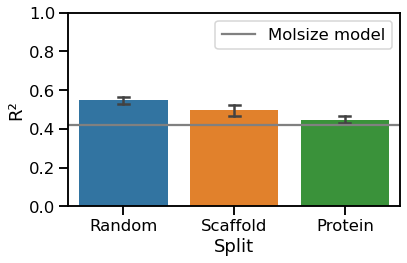

In [19]:
with sns.plotting_context('talk') :
    merged_data['Split'] = merged_data['split'].replace({'random' : 'Random',
                                            'scaffold' : 'Scaffold',
                                            'protein' : 'Protein'})
    sns.barplot(data=merged_data[merged_data['Conformation subset'] == 'All'] ,
                x='Split', y='R2', capsize=.1, errwidth=2.5)
    plt.axhline(y=0.42, color='grey', linestyle='-', label='Molsize model')
    plt.ylim(0, 1)
    plt.ylabel('R²')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/R2_barplot.png', dpi=300)

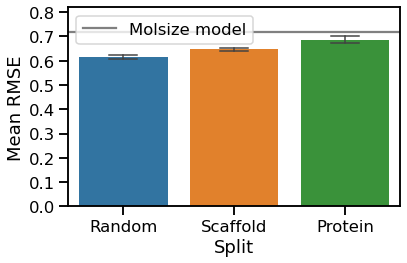

In [20]:
with sns.plotting_context('talk') :
    merged_data['Split'] = merged_data['split'].replace({'random' : 'Random',
                                            'scaffold' : 'Scaffold',
                                            'protein' : 'Protein'})
    sns.barplot(data=merged_data[merged_data['Conformation subset'] == 'All'] ,
                x='Split', y='Mean RMSE', capsize=.25, errwidth=1.5)
    plt.axhline(y=0.72, color='grey', linestyle='-', label='Molsize model')
    plt.ylim(0, 0.82)
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/RMSE_barplot.png', dpi=300)

In [21]:
grouped_data

Conformation subset          All                 Bioactive        Generated  \
                       Mean RMSE           R2    Mean RMSE  R2    Mean RMSE   
Split                                                                         
Random               0.62 ± 0.01  0.55 ± 0.03  1.34 ± 0.14  NA  0.61 ± 0.01   
Scaffold             0.65 ± 0.01   0.5 ± 0.05  1.43 ± 0.11  NA  0.64 ± 0.01   
Protein              0.69 ± 0.03  0.45 ± 0.03   1.5 ± 0.07  NA  0.68 ± 0.03   

Conformation subset               
                              R2  
Split                             
Random               0.55 ± 0.03  
Scaffold              0.5 ± 0.05  
Protein              0.45 ± 0.03

In [22]:
rmselabel = 'Mean RMSE'
r2label = 'R2'
new_data = regression_df[(regression_df['dataset'] == dataset) 
                         & (regression_df['average_type'] == 'Micro') 
                         & (regression_df['task'] == 'hard')]
all_data = new_data[['split', 'rmse_all', 'r2_all']]
all_data = all_data.rename({'rmse_all' : rmselabel, 'r2_all' : r2label}, axis=1)
all_data['Conformation subset'] = 'All'
gen_data = new_data[['split', 'rmse_gen', 'r2_gen']]
gen_data = gen_data.rename({'rmse_gen' : rmselabel, 'r2_gen' : r2label}, axis=1)
gen_data['Conformation subset'] = 'Generated'
bio_data = new_data[['split', 'rmse_bio']]
bio_data = bio_data.rename({'rmse_bio' : rmselabel}, axis=1)
bio_data['Conformation subset'] = 'Bioactive'
merged_data = pd.concat([all_data, gen_data, bio_data])

grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({rmselabel : [custom_agg],
                                                                                     r2label : [custom_agg]})
grouped_data = grouped_data.unstack(0)
grouped_data = grouped_data.droplevel(1, axis=1)
grouped_data.index.name = 'Split'
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data = grouped_data.swaplevel(axis=1)
grouped_data = grouped_data.sort_index(axis=1)

In [23]:
grouped_data

Conformation subset          All                 Bioactive        Generated  \
                       Mean RMSE           R2    Mean RMSE  R2    Mean RMSE   
Split                                                                         
Random               0.62 ± 0.01  0.52 ± 0.03  1.58 ± 0.17  NA  0.61 ± 0.01   
Scaffold             0.66 ± 0.01  0.47 ± 0.05  1.75 ± 0.13  NA  0.65 ± 0.01   
Protein               0.7 ± 0.03  0.42 ± 0.04  1.83 ± 0.09  NA  0.69 ± 0.03   

Conformation subset               
                              R2  
Split                             
Random               0.53 ± 0.02  
Scaffold             0.47 ± 0.05  
Protein              0.42 ± 0.04

# Bioactive conformation identification

In [24]:
bioactive_accuracy_df['subset'] = bioactive_accuracy_df['task']

In [25]:
bioactive_accuracy_df['ranker'] = bioactive_accuracy_df['ranker'].replace({'model' : 'BioSchNet',
                                                                          'energy' : 'UFF energy',
                                                                          'random' : 'Random'})

In [26]:
bioactive_accuracy_df.head()

,dataset,mean_top1_accuracy,median_all_bioactive,median_min_bioactive,median_normalized_bioactive,q1_all_bioactive,q1_min_bioactive,q1_normalized_bioactive,q3_all_bioactive,q3_min_bioactive,q3_normalized_bioactive,ranker,split,task,subset
0,pdbbind,0.217681,11.0,9.0,0.130435,2.0,1.0,0.010582,51.0,55.00,0.418750,BioSchNet,random,all,all
1,pdbbind,0.144287,42.0,45.0,0.426295,4.0,4.0,0.091271,160.0,164.50,0.809144,UFF energy,random,all,all
2,pdbbind,0.045872,56.0,57.0,0.406897,11.0,10.0,0.190476,141.0,136.00,0.708240,Random,random,all,all
3,pdbbind,0.222672,5.0,4.0,0.166667,1.0,1.0,0.021181,17.0,15.75,0.479048,BioSchNet,random,easy,easy
4,pdbbind,0.216599,8.0,6.0,0.333333,2.0,1.0,0.046599,34.0,33.00,0.698228,UFF energy,random,easy,easy


In [27]:
ratiolabel = 'Fraction of molecules with bioactive ranked first'
ranklabel = 'Median normalized rank of bioactive conformation'
new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                         & (bioactive_accuracy_df['task'] == 'all')]
new_data = new_data.rename({'mean_top1_accuracy' : ratiolabel,
                           'median_normalized_bioactive' : ranklabel}, axis=1)

# new_data.sort_values('ranker', key=)

grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
#grouped_data = grouped_data.rename({name[1] : name[1].capitalize() for name in grouped_data.columns}, axis=1, level=1)

In [28]:
grouped_data

Fraction of molecules with bioactive ranked first               \
Ranker                                           BioSchNet   UFF energy   
Split                                                                     
Random                                         0.22 ± 0.03  0.15 ± 0.01   
Scaffold                                       0.16 ± 0.01  0.16 ± 0.01   
Protein                                        0.12 ± 0.02  0.15 ± 0.01   

                      Median normalized rank of bioactive conformation  \
Ranker         Random                                        BioSchNet   
Split                                                                    
Random    0.04 ± 0.01                                      0.13 ± 0.02   
Scaffold  0.04 ± 0.01                                      0.19 ± 0.02   
Protein    0.04 ± 0.0                                      0.27 ± 0.03   

                                    
Ranker     UFF energy       Random  
Split                               
Random    0.42 ± 0.02  0.45 ± 0.03  
Scaffold  0.42 ± 0.03  0.44 ± 0.02  
Protein   0.46 ± 0.03  0.46 ± 0.01

In [29]:
ratiolabel = 'Fraction of molecules with bioactive ranked first'
ranklabel = 'Median normalized rank of bioactive conformation'
new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                         & (bioactive_accuracy_df['task'] == 'hard')]
new_data = new_data.rename({'mean_top1_accuracy' : ratiolabel,
                           'median_normalized_bioactive' : ranklabel}, axis=1)

grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
#grouped_data = grouped_data.rename({name[1] : name[1].capitalize() for name in grouped_data.columns}, axis=1, level=1)

In [30]:
grouped_data

Fraction of molecules with bioactive ranked first               \
Ranker                                           BioSchNet   UFF energy   
Split                                                                     
Random                                         0.21 ± 0.04  0.11 ± 0.02   
Scaffold                                       0.14 ± 0.01  0.11 ± 0.02   
Protein                                         0.1 ± 0.02  0.11 ± 0.02   

                    Median normalized rank of bioactive conformation  \
Ranker       Random                                        BioSchNet   
Split                                                                  
Random    0.0 ± 0.0                                      0.08 ± 0.02   
Scaffold  0.0 ± 0.0                                      0.15 ± 0.01   
Protein   0.0 ± 0.0                                      0.25 ± 0.03   

                                    
Ranker     UFF energy       Random  
Split                               
Random    0.48 ± 0.02  0.47 ± 0.03  
Scaffold  0.48 ± 0.04  0.46 ± 0.02  
Protein   0.52 ± 0.06  0.47 ± 0.02

# Ranking

In [31]:
ranking_df['subset'] = ranking_df['task']

In [32]:
ranking_df.head()

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,normalized_ef_0.95,normalized_ef_0.96,normalized_ef_0.97,normalized_ef_0.98,normalized_ef_0.99,normalized_ef_1.0,ranker,split,task,subset
0,0.291540,pdbbind,1.038408,0.980769,0.973877,0.986191,0.977957,0.972603,1.011205,1.005296,...,0.284638,0.284575,0.284787,0.284738,0.284776,0.284787,random,random,all,all
1,0.353319,pdbbind,1.866428,1.733745,1.546302,1.568401,1.487662,1.431131,1.416971,1.419951,...,0.286178,0.285892,0.285628,0.285323,0.284939,0.284787,energy,random,all,all
2,0.353488,pdbbind,1.335445,1.338974,1.322717,1.326504,1.272690,1.265247,1.265847,1.270141,...,0.285630,0.285415,0.285102,0.284977,0.284857,0.284787,ccdc,random,all,all
3,0.479574,pdbbind,3.990092,3.570187,3.120605,2.963276,2.808162,2.738885,2.682130,2.596960,...,0.288518,0.287597,0.286658,0.285917,0.285197,0.284787,model,random,all,all
4,0.478480,pdbbind,1.013539,0.983521,0.983794,0.973781,0.956914,0.973155,0.989373,0.998661,...,0.489385,0.489305,0.489753,0.489668,0.489700,0.489798,random,random,easy,easy


In [33]:
def custom_ranker_order(series) :
    d = {'BioSchNet' : 0,
         'CCDC' : 1,
         'UFF energy' : 2,
         'Random' : 3}
    return [d[s] for s in series]

In [34]:
ratiolabel = 'Fraction of molecules with bioactive-like ranked first'
ranklabel = 'Median normalized rank of first bioactive-like conformation'
new_data = ranking_df[(ranking_df['dataset'] == dataset) 
                         & (ranking_df['task'] == 'all')]
new_data = new_data.rename({'fraction_top_bioactive_like' : ratiolabel,
                           'median_normalized_bioactive_like_rank' : ranklabel}, axis=1)

new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})

new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')
grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
#grouped_data = grouped_data.rename({name[1] : name[1].capitalize() for name in grouped_data.columns}, axis=1, level=1)

In [35]:
grouped_data

Fraction of molecules with bioactive-like ranked first               \
Ranker                                                    model         ccdc   
Split                                                                          
Random                                          0.43 ± 0.02      0.36 ± 0.01   
Scaffold                                        0.39 ± 0.04      0.37 ± 0.04   
Protein                                         0.39 ± 0.04      0.39 ± 0.02   

                                    \
Ranker         energy       random   
Split                                
Random    0.35 ± 0.02  0.28 ± 0.01   
Scaffold  0.37 ± 0.05   0.3 ± 0.04   
Protein   0.38 ± 0.02  0.32 ± 0.02   

         Median normalized rank of first bioactive-like conformation  \
Ranker                                                         model   
Split                                                                  
Random                                           0.01 ± 0.0            
Scaffold                                         0.01 ± 0.0            
Protein                                          0.01 ± 0.0            

                                                
Ranker          ccdc       energy       random  
Split                                           
Random    0.02 ± 0.0   0.02 ± 0.0   0.02 ± 0.0  
Scaffold  0.01 ± 0.0  0.02 ± 0.01  0.02 ± 0.01  
Protein   0.01 ± 0.0   0.01 ± 0.0   0.02 ± 0.0

In [36]:
def custom_split_order(series) :
    d = {'Random' : 0,
         'Scaffold' : 1,
         'Protein' : 2}
    return [d[s] for s in series]

In [37]:
ylabel = 'Mean EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'all')]
new_data = new_data.rename({'ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [38]:
grouped_data

Mean EF at fraction = 0.1                                       
Ranker                   BioSchNet         CCDC   UFF energy       Random
Split                                                                    
Random                 2.32 ± 0.13  1.23 ± 0.03  1.36 ± 0.04  0.99 ± 0.01
Scaffold               1.97 ± 0.12  1.25 ± 0.03  1.29 ± 0.05   1.0 ± 0.02
Protein                1.57 ± 0.08  1.25 ± 0.03  1.33 ± 0.03  0.98 ± 0.02

In [39]:
ylabel = 'BEDROC'
new_data = ranking_df[(ranking_df['task'] == 'all')]
new_data = new_data.rename({'bedroc' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [40]:
grouped_data

BEDROC                                       
Ranker      BioSchNet         CCDC   UFF energy       Random
Split                                                       
Random    0.46 ± 0.02  0.35 ± 0.01  0.35 ± 0.01   0.3 ± 0.01
Scaffold  0.42 ± 0.03  0.37 ± 0.04  0.36 ± 0.04  0.31 ± 0.04
Protein   0.41 ± 0.03  0.38 ± 0.02  0.38 ± 0.02  0.32 ± 0.02

In [41]:
ylabel = 'Mean EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'hard')]
new_data = new_data.rename({'ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [42]:
grouped_data

Mean EF at fraction = 0.1                                       
Ranker                   BioSchNet         CCDC   UFF energy       Random
Split                                                                    
Random                  3.01 ± 0.2  1.23 ± 0.02   1.5 ± 0.06  0.98 ± 0.01
Scaffold               2.45 ± 0.09  1.24 ± 0.03  1.37 ± 0.07   1.0 ± 0.05
Protein                1.81 ± 0.11   1.3 ± 0.06  1.48 ± 0.04  0.97 ± 0.05

In [43]:
ylabel = 'Mean normalized EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'all')]
new_data = new_data.rename({'normalized_ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [44]:
grouped_data

Mean normalized EF at fraction = 0.1                            \
Ranker                              BioSchNet         CCDC   UFF energy   
Split                                                                     
Random                             0.4 ± 0.02  0.33 ± 0.01  0.32 ± 0.01   
Scaffold                          0.38 ± 0.04  0.35 ± 0.04  0.33 ± 0.04   
Protein                           0.39 ± 0.03  0.36 ± 0.02  0.35 ± 0.03   

                       
Ranker         Random  
Split                  
Random    0.28 ± 0.01  
Scaffold  0.29 ± 0.04  
Protein   0.31 ± 0.02

In [45]:
ranker_name_to_clean = {'random' : 'Random',
                                     'energy' : 'UFF energy',
                                     'ccdc' : 'CCDC',
                                     'model_random' : 'BioSchNet (random split)',
                                     'model_scaffold' : 'BioSchNet (scaffold split)',
                                     'model_protein' : 'BioSchNet (protein split)'}

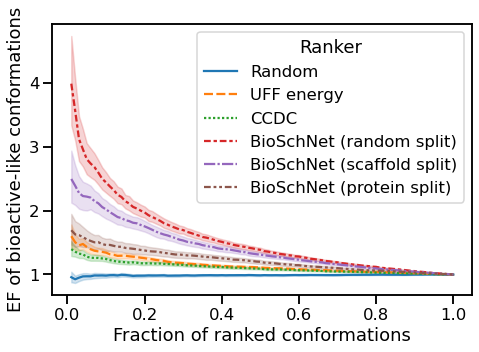

In [49]:
dataset = 'pdbbind'
task = 'all'
df = pd.DataFrame()
xlabel = 'Fraction of ranked generated conformations'
ylabel = 'EF of bioactive-like conformations'
for split in splits :
    evaluation_name = f'{split}_split_0'
    ef_df_path = os.path.join(results_dir,
                              evaluation_name,
                              task,
                              'ef_df.csv')
    ef_df = pd.read_csv(ef_df_path, index_col=0)
    ef_df['ranker'] = ef_df['ranker'].replace({'model' : f'model_{split}'})
    ef_df = ef_df.rename({'Fraction' : xlabel,
                          'Enrichment factor' : ylabel}, axis=1)
    df = df.append(ef_df, ignore_index=True)

df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)
    
# xlabel2 = 'Percentage of ranked generated conformations'
# df[xlabel2] = df[xlabel] * 100
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=df, x=xlabel, y=ylabel, hue='Ranker', style='Ranker')
    #plt.title(f'Generated conformation ranking evaluation ({dataset})')
    plt.xlabel('Fraction of ranked conformations')
    fig_path = os.path.join('figures/', 
                            f'efs_{dataset}.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()

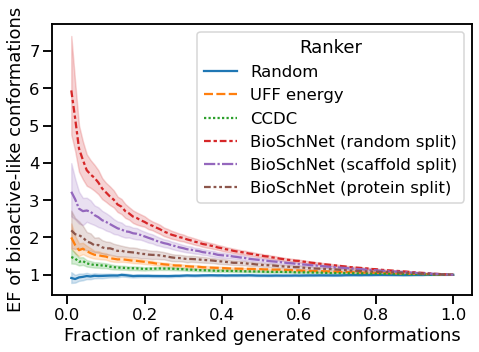

In [52]:
dataset = 'pdbbind'
task = 'hard'
df = pd.DataFrame()
xlabel = 'Fraction of ranked generated conformations'
ylabel = 'EF of bioactive-like conformations'
for split in splits :
    evaluation_name = f'{split}_split_0'
    ef_df_path = os.path.join(results_dir,
                              evaluation_name,
                              task,
                              'ef_df.csv')
    ef_df = pd.read_csv(ef_df_path, index_col=0)
    ef_df['ranker'] = ef_df['ranker'].replace({'model' : f'model_{split}'})
    ef_df = ef_df.rename({'Fraction' : xlabel,
                          'Enrichment factor' : ylabel}, axis=1)
    df = df.append(ef_df, ignore_index=True)

df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=df, x=xlabel, y=ylabel, hue='Ranker', style='Ranker')
    #plt.title(f'Generated conformation ranking evaluation ({dataset})')
    plt.xlabel('Fraction of ranked generated conformations')
    fig_path = os.path.join('figures/', 
                            f'efs_{dataset}.png')
    plt.tight_layout()
    #plt.savefig(fig_path, dpi=300)
    plt.show()

# Rigid ligand docking

In [ ]:
ranker_name_to_clean['score'] = 'PLP score'

In [ ]:
def custom_ranker_order(series) :
    ranked_list = ['Random', 'UFF energy', 'CCDC',
                   'BioSchNet (random split)',
                   'BioSchNet (scaffold split)',
                   'BioSchNet (protein split)',
                   'PLP score']
    d = {ranker : i 
         for i, ranker in enumerate(ranked_list)}
    return [d[s] for s in series]

In [ ]:
def get_title(metric) :
    if metric == 'first_successful_pose' :
        title = 'Successful docking'
    elif metric == 'ligand_rmsd' :
        title = 'Retrieval of best pose (among successful docking)'
    else :
        title = f'Retrieval of top {metric}'
    return title

In [ ]:
flexible_docking_powers = {
    'random' : 0.79,
    'scaffold' : 0.77,
    'protein' : 0.71
}

flexible_generation_powers = {
    'random' : 0.84,
    'scaffold' : 0.83,
    'protein' : 0.84
}

In [ ]:
splits = ['random', 'scaffold', 'protein']
df = pd.DataFrame()
for split in splits :
    for iteration in range(5) :
        evaluation_name = f'{split}_split_{iteration}_pdbbind'
        recall_df_path = os.path.join('results/',
                                 evaluation_name,
                                 'rigid_ligand_docking_recall_all.csv')
        recall_df = pd.read_csv(recall_df_path, index_col=0)
        recall_df['Number of input conformations'] = recall_df['Number of input conformations'] + 1
        recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
        recall_df['baseline'] = split
        recall_df['iteration'] = iteration
        flexible_docking_power = flexible_docking_powers[split]
#         print(recall_df[(recall_df['Recall'] >= flexible_docking_power) 
#                   & (recall_df['metric'] == 'first_successful_pose')].drop_duplicates(subset='ranker')[['Number of input conformations', 'ranker']])
        df = df.append(recall_df, ignore_index=True)
df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)

In [ ]:
df[(df['Number of input conformations'] == 100) & (df['metric'] == 'first_successful_pose')].groupby('ranker').agg({'Recall' : ['mean', 'std']})

In [ ]:
# Docking power 75%
n_docking_power = df[(df['Recall'] >= 0.75) & (df['metric'] == 'first_successful_pose')].drop_duplicates(subset=['Ranker', 'baseline', 'iteration'])# .groupby('ranker').agg({'Conformation rank' : ['mean', 'std']})

In [ ]:
n_docking_power.groupby('Ranker').agg(['mean', 'std'])

In [ ]:
df = df.sort_values(by='Ranker', key=custom_ranker_order)

In [ ]:
metric = 'first_successful_pose'

metric_df = df[df['metric'] == metric]
#metric_df = metric_df[metric_df['Ranker'] !='PLP score']

# title = get_title(metric)
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(7.5, 7.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y='Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of molecules with successful docking')
    plt.ylim(0, 1)
    plt.xticks([1] + list(range(10, 101, 10)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()

    plt.figure(figsize=(7.5, 7.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y='Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of molecules with successful docking')
    plt.xlim(0, 20)
    plt.ylim(0, 1)
    plt.xticks([1] + list(range(2, 21, 2)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking_truncated.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()
    plt.close()

In [ ]:
df = pd.DataFrame()
for split in splits :
    for iteration in range(5) :
        evaluation_name = f'{split}_split_{iteration}_pdbbind'
        recall_df_path = os.path.join('results/',
                                 evaluation_name,
                                 'rigid_ligand_docking_recall_successful_only.csv')
        recall_df = pd.read_csv(recall_df_path, index_col=0)
        recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
        recall_df['iteration'] = iteration
        df = df.append(recall_df, ignore_index=True)
df['Ranker'] = df['ranker'].replace(ranker_name_to_clean)
df = df.sort_values(by='Ranker', key=custom_ranker_order)

In [ ]:
df['Number of input conformations'] = df['Number of input conformations'] + 1

In [ ]:
df[(df['Number of input conformations'] == 20) & (df['metric'] == 'ligand_rmsd')].groupby('Ranker', sort=False).agg({'Recall' : ['mean', 'std']})

In [ ]:
df['metric'].unique()

In [ ]:
metric = 'ligand_rmsd'

metric_df = df[df['metric'] == metric]
#metric_df = metric_df[metric_df['Ranker'] !='PLP score']

title = get_title(metric)
    
with sns.plotting_context('talk') :
    plt.figure(figsize=(8.5, 8.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y=f'Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of best poses retrieved (successful docking only)')
    plt.xticks([1] + list(range(10, 101, 10)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking.png')
    #plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()

    plt.figure(figsize=(8.5, 8.5))
    sns.lineplot(data=metric_df, 
                 x='Number of input conformations', 
                 y=f'Recall', 
                 hue='Ranker',
                 style='Ranker')
    # plt.title(title)
    plt.ylabel('Fraction of best poses retrieved (successful docking only)')
    plt.xlim(0, 20)
    plt.xticks([1] + list(range(2, 21, 2)))
    plt.yticks(np.arange(0, 1.1, 0.1))
    fig_path = os.path.join('figures/', 
                            f'{metric}_rigid_docking_truncated.png')
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()
    plt.close()